## Focus Fiduciary Check
**Author:** [Aaron Woods](https://aaronwoods.info)<br>
**Date created:** 2023/09/07<br>
**Description:** This script demonstrates how to build a binary classifier model for the task of classifying images as "In Focus" or "Out of Focus".
https://insiders.vscode.dev/tunnel/midnightsim/c:/Users/User/Desktop/Image-Classification

## Setup

In [183]:
!pip install numpy pandas matplotlib protobuf seaborn scikit-learn tensorflow > /dev/null 2>&1
# To suprress the output we use > /dev/null 2>&1

The system cannot find the path specified.


In [184]:
# Standard Libraries
import os
import sys
import random
import math
from datetime import datetime
import logging
import glob 

# Third-Party Libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight
from IPython.display import clear_output
from collections import defaultdict

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.callbacks import TensorBoard, Callback
from tensorflow.keras.applications import InceptionV3, ResNet50
from keras.models import load_model
import pickle

# Type Annotations
from typing import List, Dict, Tuple, Union, Any, Optional

# Check for GPU support
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")


No GPU was detected. Neural nets can be very slow without a GPU.


## Configuration

In [185]:
# @title Configuration

# Configuration dictionary
config = {
    'Experiment': {
        'NAME': "Multi-Class_Thresholds-30-60-1-2",
        'RANDOM_SEED': 42,
    },
    'Model': {
        'IMG_SIZE': 224,
        'BATCH_SIZE': 16,
        'EPOCHS': 100,
        'LEARNING_RATE': 1e-3,
        'EARLY_STOPPING_PATIENCE': 5,
        'REDUCE_LR_PATIENCE': 3,
        'MIN_LR': 1e-6,
        'LOSS': "categorical_crossentropy",  # Updated for multi-class
        'TRAIN_SIZE': 0.8,
        'VAL_SIZE': 0.5,
    },
    'Thresholds': {
        'FOCUS_LOW': 30,
        'FOCUS_HIGH': 60,
        'STIG_LOW': 1,
        'STIG_HIGH': 2,
    },
    'Labels': {
        'MAPPINGS': {
            'Focus_Label': {'SharpFocus': 0, 'SlightlyBlurred': 1, 'HighlyBlurred': 2},
            'StigX_Label': {'OptimalStig_X': 0, 'ModerateStig_X': 1, 'SevereStig_X': 2},
            'StigY_Label': {'OptimalStig_Y': 0, 'ModerateStig_Y': 1, 'SevereStig_Y': 2},
        }
    },
    'Paths': {
        'BASE_DIR': "C:\\Users\\User\\Desktop\\DOE_v2\\",
        'DATA_FILE': "combined_output.csv",
        'OLD_BASE_PATH': "D:\\DOE\\",
        'NEW_BASE_PATH': "C:\\Users\\User\\Desktop\\DOE_v2\\",
    },
    'Augmentation': {
        'rotation_factor': 0.005,
        'height_factor': (-0.15, 0.15),
        'width_factor': (-0.15, 0.15),
        'contrast_factor': (0.7, 1.3),
        'brightness_factor': (-0.2, 0.2)
    }
}

# Random seed for reproducibility
np.random.seed(config['Experiment']['RANDOM_SEED'])
tf.random.set_seed(config['Experiment']['RANDOM_SEED'])

## Defining the Models

In [186]:
# Transfer learning models
def create_transfer_model(base_model, input_shape: tuple, num_classes: int, hidden_units: list, dropout_rate: float, regularizer_rate: float) -> keras.Model:
    """Creates a transfer learning model based on a given base model."""
    base_model.trainable = False

    model = keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D()
    ])

    for units in hidden_units:
        model.add(layers.Dense(units, kernel_regularizer=keras.regularizers.l2(regularizer_rate), bias_regularizer=keras.regularizers.l2(regularizer_rate)))
        model.add(layers.LeakyReLU())
        model.add(layers.Dropout(dropout_rate))

    activation, units = ("sigmoid", 1) if num_classes == 2 else ("softmax", num_classes)
    model.add(layers.Dense(units, activation=activation))

    return model

def create_mobilenetv2_transfer_model(input_shape: tuple, num_classes: int) -> keras.Model:
    """Creates a MobileNetV2 based transfer learning model."""
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    return create_transfer_model(base_model, input_shape, num_classes, [128, 64], 0.5, 0.001)

def create_inceptionv3_transfer_model(input_shape: tuple, num_classes: int) -> keras.Model:
    """Creates an InceptionV3 based transfer learning model."""
    base_model = tf.keras.applications.InceptionV3(input_shape=input_shape, include_top=False, weights='imagenet')
    return create_transfer_model(base_model, input_shape, num_classes, [128, 64], 0.5, 0.001)

def create_resnet50_transfer_model(input_shape: tuple, num_classes: int) -> keras.Model:
    """Creates a ResNet50 based transfer learning model."""
    base_model = tf.keras.applications.ResNet50(input_shape=input_shape, include_top=False, weights='imagenet')
    return create_transfer_model(base_model, input_shape, num_classes, [256, 128], 0.5, 0.001)

In [187]:
# Define the function to create a small version of the Xception network
def create_small_xception_model(input_shape, num_classes):
    # Input layer
    inputs = keras.Input(shape=input_shape)

    # Entry block: Initial Convolution and BatchNormalization
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    previous_block_activation = x  # Set aside residual for later use

    # Middle flow: Stacking Separable Convolution blocks
    for size in [256, 512, 728]:
        # ReLU activation
        x = layers.Activation("relu")(x)
        # Separable Convolution
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        # ReLU activation
        x = layers.Activation("relu")(x)
        # Separable Convolution
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        # Max Pooling
        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual from previous block and add it to the current block
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(previous_block_activation)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Exit flow: Final Separable Convolution, BatchNormalization, and Global Average Pooling
    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.GlobalAveragePooling2D()(x)

    # Determine activation and units based on the number of classes
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    # Dropout and Dense output layer
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)

    return keras.Model(inputs, outputs)

In [188]:
# Define the function to create a basic CNN model
def create_basic_cnn_model(input_shape, num_classes):
    conv2d_filter_size = (3, 3)
    conv2d_activation = 'relu'
    dense_activation = 'relu'
    num_conv_blocks = 3

    model = tf.keras.models.Sequential()

    # Explicitly define the input shape
    model.add(tf.keras.layers.Input(shape=input_shape))

    for _ in range(num_conv_blocks):
        model.add(tf.keras.layers.Conv2D(32 * (2**_), conv2d_filter_size, activation=conv2d_activation, padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.MaxPooling2D((2, 2)))

    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(tf.keras.layers.Dense(128, activation=dense_activation))

    # Determine activation and units based on the number of classes
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    model.add(tf.keras.layers.Dense(units, activation=activation))

    return model

In [189]:
# Model Selection function to select which model to use
def select_model(model_name: str, input_shape: tuple, num_classes: int) -> keras.Model:
    """Selects a model to use based on the given model name."""
    model_map = {
        "mobilenetv2": create_mobilenetv2_transfer_model,
        "inceptionv3": create_inceptionv3_transfer_model,
        "resnet50": create_resnet50_transfer_model,
        "small_xception": create_small_xception_model,
        "basic_cnn": create_basic_cnn_model
    }
    if model_name not in model_map:
        raise ValueError("Invalid model name")

    return model_map[model_name](input_shape, num_classes)

## Load and Preprocess the data

### Image Processing Functions

In [190]:
from tensorflow import keras
from tensorflow.keras import layers
import cv2
import tensorflow as tf
from typing import Tuple

def create_preprocessing_layers(img_width: int, img_height: int, rescale_factor: float) -> keras.Sequential:
    """Create preprocessing layers for resizing and rescaling images."""
    return keras.Sequential([
        layers.Resizing(img_width, img_height),
        layers.Rescaling(rescale_factor)
    ])

def create_augmentation_layers(augmentation_config: dict) -> keras.Sequential:
    """Create data augmentation layers."""
    try:
        augmentation_layers = tf.keras.Sequential([
            layers.RandomFlip("horizontal"),
            layers.RandomFlip("vertical"),
            layers.RandomRotation(augmentation_config['rotation_factor']),
            layers.RandomTranslation(
                height_factor=augmentation_config['height_factor'],
                width_factor=augmentation_config['width_factor'],
                fill_mode="reflect"
            ),
            # Adding RandomContrast and RandomBrightness layers.
            layers.RandomContrast(augmentation_config['contrast_factor']),
            layers.RandomBrightness(augmentation_config['brightness_factor'])
        ])
    except Exception as e:
        print(f"An error occurred while creating augmentation layers: {e}")
        
    return augmentation_layers

def read_and_convert_image(file_path: str) -> tf.Tensor:
    """Read an image from a file and convert it to a 3-channel tensor."""
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    image = tf.expand_dims(image, axis=-1)
    return tf.image.grayscale_to_rgb(image)

def preprocess_image(file_path, label, augment, config: dict) -> Tuple[tf.Tensor, tf.Tensor]:
    """Preprocess an image by applying resizing, rescaling, and optional data augmentation."""
    file_path = file_path.numpy().decode("utf-8")
    
    preprocess_seq = create_preprocessing_layers(
        img_width=config['Model']['IMG_SIZE'], 
        img_height=config['Model']['IMG_SIZE'], 
        rescale_factor=1./255
    )
    augment_seq = create_augmentation_layers(config['Augmentation'])
    
    image = read_and_convert_image(file_path)
    image = preprocess_seq(image)
    
    if augment:
        image = augment_seq(image)
        
    return image, label

def preprocess_wrapper(file_path, label, augment, config: dict) -> Tuple[tf.Tensor, tf.Tensor]:
    """Wrapper function for TensorFlow's map function."""
    image, label = tf.py_function(
        func=lambda file_path, label, augment: preprocess_image(file_path, label, augment, config),
        inp=[file_path, label, augment], 
        Tout=[tf.float32, tf.int64]  # Keep this as tf.int64 for now
    )
    label.set_shape(())
    label = tf.cast(label, tf.int32)  # Explicitly cast label to tf.int32
    return image, label


def preprocess_images(train_ds, valid_ds, test_ds, config: dict):
    """Apply preprocessing to training, validation, and test datasets."""
    train_ds = train_ds.map(lambda file_path, label: preprocess_wrapper(file_path, label, True, config))
    valid_ds = valid_ds.map(lambda file_path, label: preprocess_wrapper(file_path, label, False, config))
    test_ds = test_ds.map(lambda file_path, label: preprocess_wrapper(file_path, label, False, config))
    
    return train_ds, valid_ds, test_ds


### Functions for Preparation of CSV

In [191]:
# Data Preprocessing and Dataset Preparation

import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.data import Dataset
import tensorflow as tf
from collections import Counter

def preprocess_and_prepare_tf_datasets(config: dict) -> dict:
    """Preprocess a CSV data file and prepare TensorFlow datasets."""
    
    print("===== Preprocessing CSV Data =====")
    
    # Functionality to read the data
    data_file_path = os.path.join(config['Paths']['BASE_DIR'], config['Paths']['DATA_FILE'])
    print(f"---> Reading data from: {data_file_path}")
    
    if not os.path.exists(data_file_path):
        raise FileNotFoundError(f"Error: File does not exist - {data_file_path}")
    
    try:
        data = pd.read_csv(data_file_path)
        print("---> Data read successfully.")
    except Exception as e:
        raise ValueError(f"Error: Could not read data - {e}") from e
    
    # Functionality to update image paths
    print("---> Updating image file paths...")
    data['ImageFile'] = data['ImageFile'].str.replace(config['Paths']['OLD_BASE_PATH'], config['Paths']['NEW_BASE_PATH'], regex=False)
    print("---> Image paths updated.")
    
    # Functionality to generate labels for Focus, StigX, and StigY
    print("---> Generating labels for Focus, StigX, and StigY...")
    
    focus_conditions = [
        (data['Focus_Offset (V)'].abs() <= config['Thresholds']['FOCUS_LOW']),
        (data['Focus_Offset (V)'].abs() <= config['Thresholds']['FOCUS_HIGH']),
        (data['Focus_Offset (V)'].abs() > config['Thresholds']['FOCUS_HIGH'])
    ]

    stig_x_conditions = [
        (data['Stig_Offset_X (V)'].abs() <= config['Thresholds']['STIG_LOW']),
        (data['Stig_Offset_X (V)'].abs() <= config['Thresholds']['STIG_HIGH']),
        (data['Stig_Offset_X (V)'].abs() > config['Thresholds']['STIG_HIGH'])
    ]
    
    stig_y_conditions = [
        (data['Stig_Offset_Y (V)'].abs() <= config['Thresholds']['STIG_LOW']),
        (data['Stig_Offset_Y (V)'].abs() <= config['Thresholds']['STIG_HIGH']),
        (data['Stig_Offset_Y (V)'].abs() > config['Thresholds']['STIG_HIGH'])
    ]

    focus_choices = list(config['Labels']['MAPPINGS']['Focus_Label'].keys())
    stig_x_choices = list(config['Labels']['MAPPINGS']['StigX_Label'].keys())
    stig_y_choices = list(config['Labels']['MAPPINGS']['StigY_Label'].keys())
    
    data['Focus_Label'] = np.select(focus_conditions, focus_choices)
    data['StigX_Label'] = np.select(stig_x_conditions, stig_x_choices)
    data['StigY_Label'] = np.select(stig_y_conditions, stig_y_choices)
    
    print("---> Labels generated.")

    print("===== Preparing TensorFlow Datasets =====")
    
    labeled_df = data
    datasets = {}
    labels = ['Focus_Label', 'StigX_Label', 'StigY_Label']

    # Shuffle and Reset Index
    print("---> Shuffling and resetting index...")
    labeled_df = labeled_df.sample(frac=1, random_state=config['Experiment']['RANDOM_SEED']).reset_index(drop=True)
    print("---> Data shuffled and index reset.")
    
    for label in labels:
        print(f"---> Preparing datasets for label: {label}")
        datasets[label] = {'train': None, 'valid': None, 'test': None, 'info': {}}
        

        # Split Data
        train_df, temp_df = train_test_split(labeled_df, test_size=1 - config['Model']['TRAIN_SIZE'], random_state=config['Experiment']['RANDOM_SEED'])
        val_df, test_df = train_test_split(temp_df, test_size=1 - config['Model']['VAL_SIZE'], random_state=config['Experiment']['RANDOM_SEED'])

        # Create TensorFlow Datasets
        train_ds = Dataset.from_tensor_slices((train_df['ImageFile'].values, train_df[label].map(config['Labels']['MAPPINGS'][label]).values))
        val_ds = Dataset.from_tensor_slices((val_df['ImageFile'].values, val_df[label].map(config['Labels']['MAPPINGS'][label]).values))
        test_ds = Dataset.from_tensor_slices((test_df['ImageFile'].values, test_df[label].map(config['Labels']['MAPPINGS'][label]).values))

        # Apply Preprocessing using your preprocessing functions
        train_ds, val_ds, test_ds = preprocess_images(train_ds, val_ds, test_ds, config)
        
        # # Debug/Check Statement
        # print("---> Debug Check: Verifying the first element of the train_ds after preprocessing")
        # for img, lbl in train_ds.take(1):
        #     print(f"Image shape: {img.shape}, Label: {lbl.numpy()}")


        # Configure for Performance
        AUTOTUNE = tf.data.AUTOTUNE
        train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
        val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
        test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

        # Store Datasets
        datasets[label]['train'] = train_ds
        datasets[label]['valid'] = val_ds
        datasets[label]['test'] = test_ds

        # Compute and Store Class Weights and Info for each split
        for split, df in zip(['Training', 'Validation', 'Test'], [train_df, val_df, test_df]):
            unique_labels = df[label].unique()
            class_weights = compute_class_weight('balanced', classes=unique_labels, y=df[label])
            class_weights_dict = dict(zip(unique_labels, class_weights))

            datasets[label]['info'][split] = {
                'Total': len(df),
                'ClassInfo': {cls: {'Count': cnt, 'Weight': class_weights_dict[cls]} for cls, cnt in Counter(df[label]).items()}
            }
        print(f"---> Datasets prepared for label: {label}")

    print("===== Preprocessing and Dataset Preparation Complete =====")
   

    return datasets

# Preprocess and prepare datasets
datasets = preprocess_and_prepare_tf_datasets(config)

===== Preprocessing CSV Data =====
---> Reading data from: C:\Users\User\Desktop\DOE_v2\combined_output.csv
---> Data read successfully.
---> Updating image file paths...
---> Image paths updated.
---> Generating labels for Focus, StigX, and StigY...
---> Labels generated.
===== Preparing TensorFlow Datasets =====
---> Shuffling and resetting index...
---> Data shuffled and index reset.
---> Preparing datasets for label: Focus_Label


---> Datasets prepared for label: Focus_Label
---> Preparing datasets for label: StigX_Label
---> Datasets prepared for label: StigX_Label
---> Preparing datasets for label: StigY_Label
---> Datasets prepared for label: StigY_Label
===== Preprocessing and Dataset Preparation Complete =====


In [192]:
# #  Print in a pretty format
# def print_datasets_info(datasets: dict) -> None:
#     """Print out datasets info in a pretty format."""
#     for label in datasets.keys():
#         print(f"Label: {label}")
#         for key in datasets[label]['info'].keys():
#             print(f"\t{key}:")
#             for class_label in datasets[label]['info'][key]['ClassInfo'].keys():
#                 print(f"\t\t{class_label}: {datasets[label]['info'][key]['ClassInfo'][class_label]}")
#             print(f"\t\tTotal: {datasets[label]['info'][key]['Total']}")
#         print()

# # Usage
# print_datasets_info(datasets)

## Visualize the data

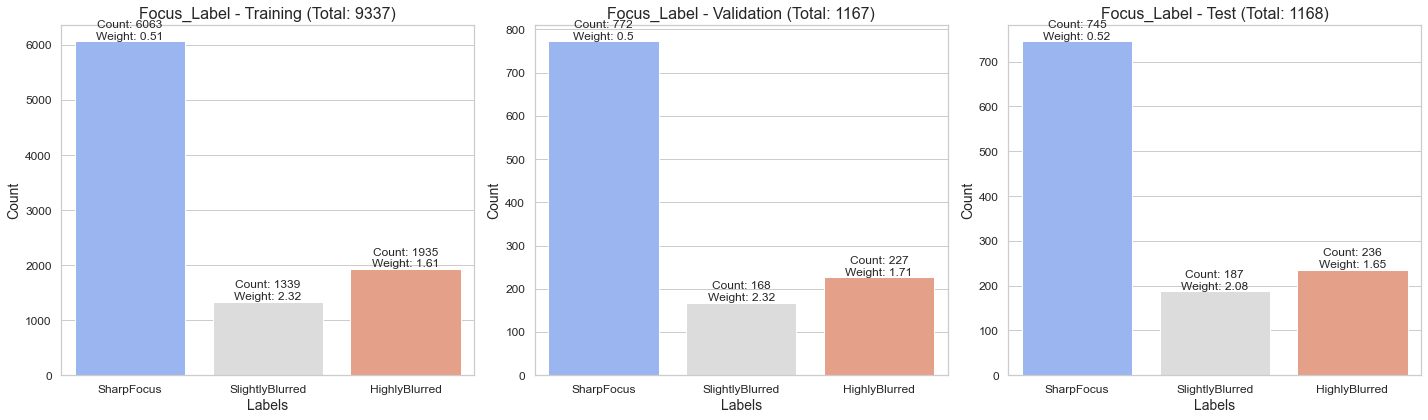

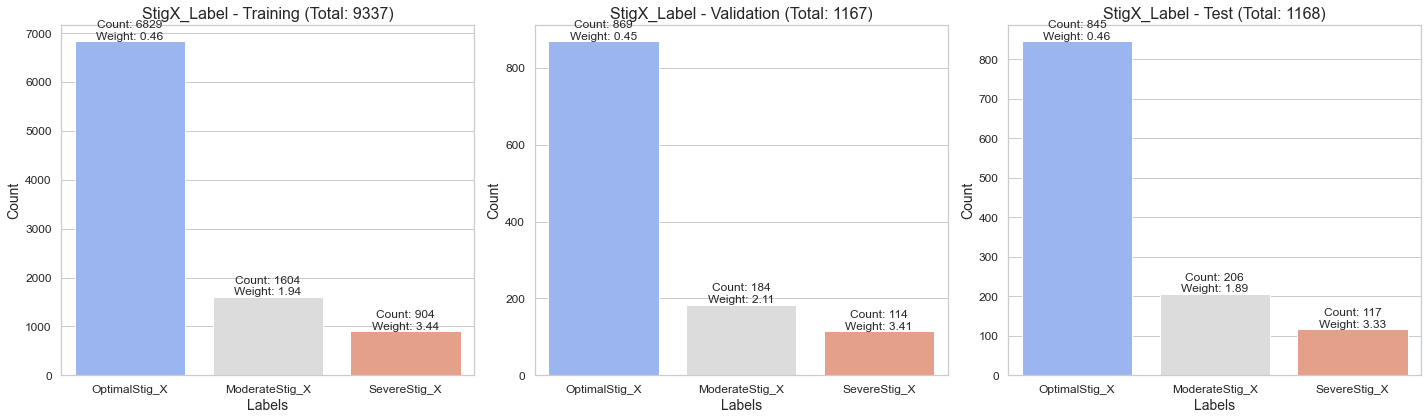

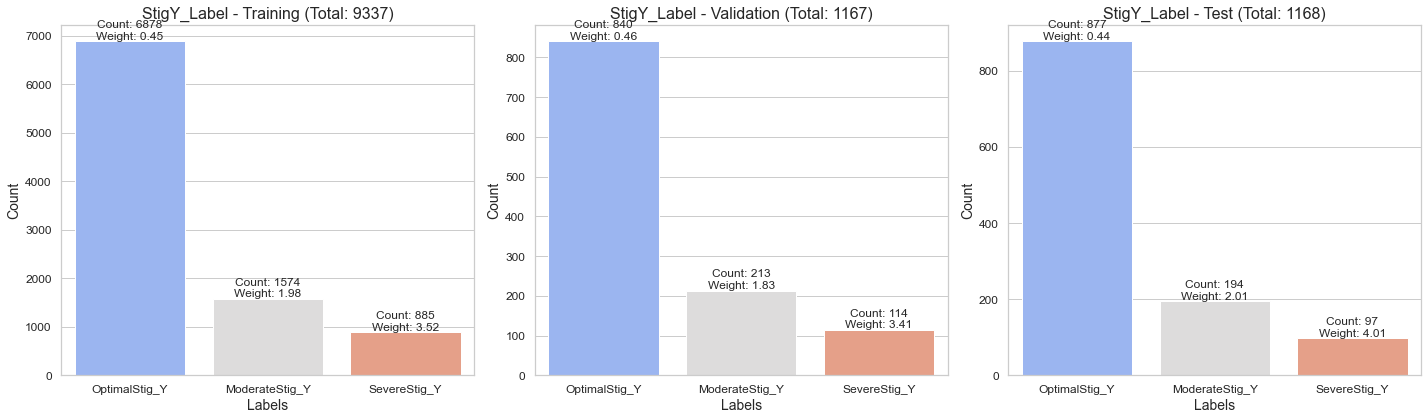

In [193]:
from typing import Dict
import seaborn as sns
import matplotlib.pyplot as plt

def annotate_bars(ax, labels, counts, weights):
    """Annotate the bars with counts and weights."""
    for i, (count, weight) in enumerate(zip(counts, weights)):
        ax.text(i, count, f"Count: {count}\nWeight: {round(weight, 2)}", ha='center', va='bottom')

def plot_single_split(ax, split_data: Dict, label_column: str, split: str, sorted_labels: list) -> None:
    
    # Sort based on preferred order
    counts = [split_data['ClassInfo'].get(label, {'Count': 0})['Count'] for label in sorted_labels]
    weights = [split_data['ClassInfo'].get(label, {'Weight': 0})['Weight'] for label in sorted_labels]
    
    sns.barplot(x=sorted_labels, y=counts, ax=ax, palette="coolwarm")
    annotate_bars(ax, sorted_labels, counts, weights)

    ax.set_title(f"{label_column} - {split} (Total: {split_data['Total']})", fontsize=16)
    ax.set_xlabel('Labels', fontsize=14)
    ax.set_ylabel('Count', fontsize=14)
    ax.tick_params(labelsize=12)

def plot_academic_dataset_info(datasets: Dict) -> None:
    """Enhance the plots for a more academic/scientific look using seaborn."""
    sns.set(style="whitegrid")

    # Define the preferred label order
    focus_labels_order = ['SharpFocus', 'SlightlyBlurred', 'HighlyBlurred']
    stig_labels_order = ['OptimalStig', 'ModerateStig', 'SevereStig']

    for label_column, data in datasets.items():

        # Choose the preferred label order based on the label_column
        if 'Focus' in label_column:
            sorted_labels = focus_labels_order
        else:  # For 'StigX' and 'StigY'
            sorted_labels = [
                f'{label}_X' if 'X' in label_column else f'{label}_Y'
                for label in stig_labels_order
            ]

        fig, axs = plt.subplots(1, 3, figsize=(20, 6))

        for i, split in enumerate(['Training', 'Validation', 'Test']):
            plot_single_split(axs[i], data['info'][split], label_column, split, sorted_labels)

        plt.tight_layout()
        plt.show()


# Call the function
# Assuming 'datasets' is your prepared dataset dictionary
plot_academic_dataset_info(datasets)  


Visualizing 3 x 3 samples of each class for Focus_Label...


c:\Program Files\Python36\envs\AutoScript\lib\site-packages\ipykernel_launcher.py:52: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


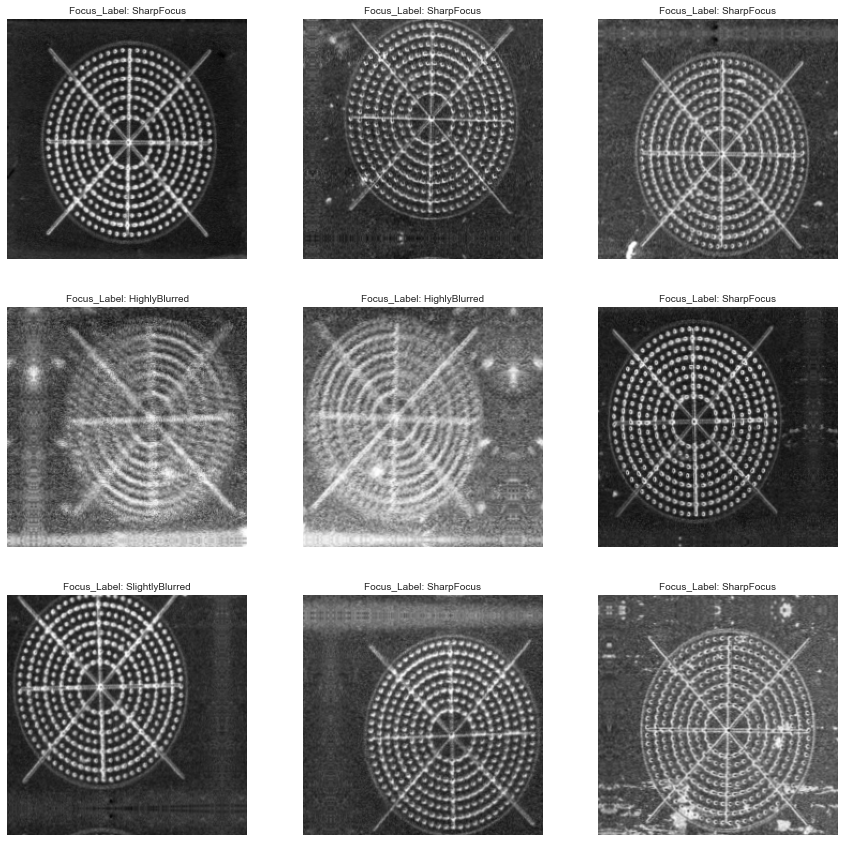

Visualizing 3 x 3 samples of each class for StigX_Label...


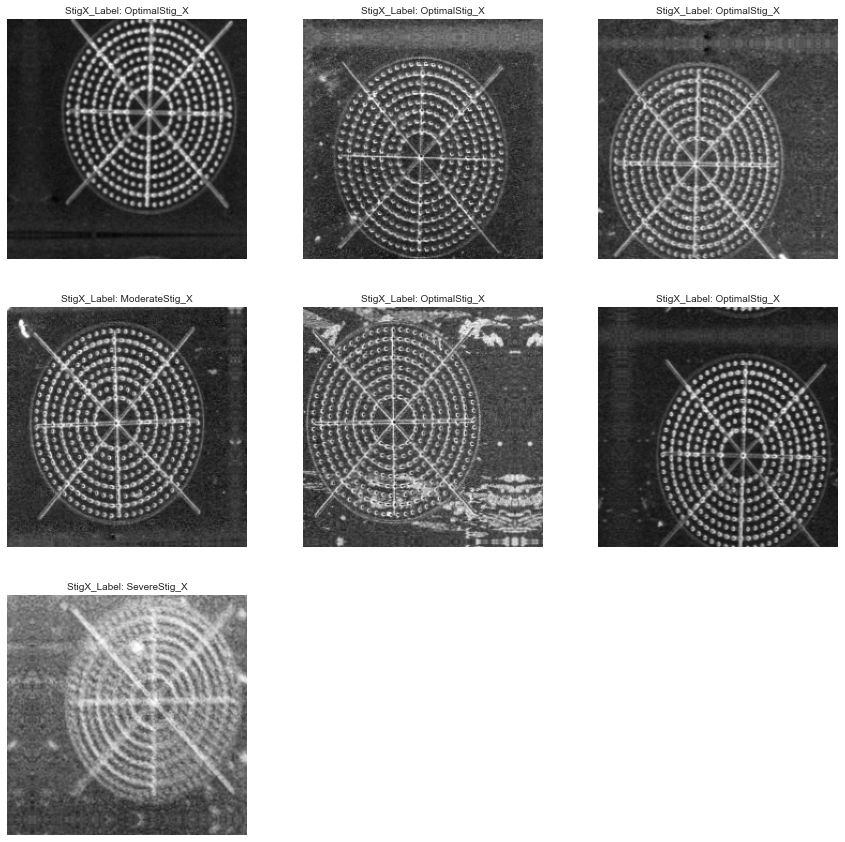

Visualizing 3 x 3 samples of each class for StigY_Label...


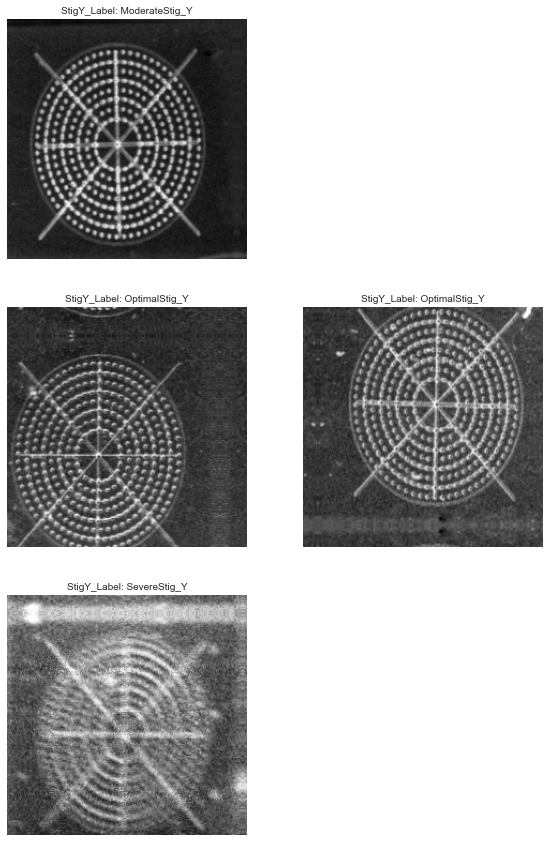

In [194]:
import itertools
import matplotlib.pyplot as plt

def find_class_name(label: int, mappings: Dict[str, int], default="Unknown") -> str:
    """Find class name from label."""
    return next((name for name, idx in mappings.items() if idx == label), default)

def visualize_and_show_batch(datasets: Dict[str, Dict[str, Any]], config: Dict[str, Any], rows: int = 3, cols: int = 3, samples_per_class: int = 9) -> None:
    """
    Visualize datasets with multiple samples from each class and display a batch of images with labels.
    
    :param datasets: Dictionary containing dataset information.
    :param config: Configuration dictionary.
    :param rows: Number of rows for displaying images.
    :param cols: Number of columns for displaying images.
    :param samples_per_class: Number of samples per class to display.
    """
    for label_column, dataset_info in datasets.items():
        class_to_samples = []
        class_names = []
        
        for image_batch, label_batch in dataset_info.get('train', []).batch(1):
            label = int(label_batch.numpy()[0])
            class_name = find_class_name(label, config['Labels']['MAPPINGS'].get(label_column, {}))
            
            if class_name not in class_names:
                class_names.append(class_name)
                class_to_samples.append([image_batch[0].numpy()])
                counter = 1 # initialize counter for each new class
            else:
                class_idx = class_names.index(class_name)
                class_to_samples[class_idx].append(image_batch[0].numpy())
                counter += 1 # increment counter for existing class
            
            if len(class_to_samples) == len(config['Labels']['MAPPINGS'].get(label_column, {})):
                for i, j in itertools.product(range(rows), range(samples_per_class)):
                    if i >= len(class_to_samples) or j >= len(class_to_samples[i]):
                        i = i % len(class_to_samples)  # Wrap around to the available classes
                        j = j % len(class_to_samples[i])  # Wrap around to the available samples in the class
                break
        
        print(f"Visualizing {rows} x {cols} samples of each class for {label_column}...")
        
        # Display the batch of images with labels
        plt.figure(figsize=(15, 5 * rows))
        for i, j in itertools.product(range(rows), range(samples_per_class)):
            
            if i >= len(class_to_samples) or j >= len(class_to_samples[i]):
                i = i % len(class_to_samples)  # Wrap around to the available classes
                j = j % len(class_to_samples[i])  # Wrap around to the available samples in the class
            
            ax = plt.subplot(rows, cols, i * cols + j + 1)
            plt.imshow(class_to_samples[i][j], cmap="gray")
            label_text = "\n".join((f"{key}: {val[i]}" for key, val in {label_column: class_names}.items()))
            ax.set_title(label_text, fontsize=10)  # Set a unique title for each axes instance
            plt.axis('off')
        
        plt.show()

# Example usage
visualize_and_show_batch(datasets, config)


## Define the Callbacks

### Per Class Metrics

In [200]:
from tensorflow.keras.metrics import TruePositives, FalsePositives, TrueNegatives, FalseNegatives, Precision, Recall, AUC

def get_per_class_metrics(num_classes):
    metrics = ["accuracy"]
    
    for i in range(num_classes):
        metrics.extend([
            TruePositives(name=f"true_positives_class_{i}"),
            FalsePositives(name=f"false_positives_class_{i}"),
            TrueNegatives(name=f"true_negatives_class_{i}"),
            FalseNegatives(name=f"false_negatives_class_{i}"),
            Precision(name=f"precision_class_{i}"),
            Recall(name=f"recall_class_{i}"),
            AUC(name=f"auc_class_{i}") 
        ])
        
    return metrics

num_classes = len(config['Labels']['MAPPINGS']['Focus_Label'])
config['METRICS'] = get_per_class_metrics(num_classes)


### Defining Models and Callbacks

In [208]:
# @title Constants and Helper Functions
BASE_DIR = os.path.expanduser("~")
MODELS_DIR_NAME = "models"
LOG_DIR_NAME = "logs/fit"
DEFAULT_INPUT_SHAPE = (config['Model']['IMG_SIZE'], config['Model']['IMG_SIZE'], 3)

DEFAULT_NUM_CLASSES = 3

# Model configurations
MODEL_CONFIGS = {
    'mobilenetv2': {'model_fn': create_mobilenetv2_transfer_model},
    'small_xception': {'model_fn': create_small_xception_model},
    'basic_cnn': {'model_fn': create_basic_cnn_model},
    'inceptionv3': {'model_fn': create_inceptionv3_transfer_model},
    'resnet50': {'model_fn': create_resnet50_transfer_model}
}

# Set default configurations
for config_name in MODEL_CONFIGS:
    MODEL_CONFIGS[config_name].setdefault('input_shape', DEFAULT_INPUT_SHAPE)
    MODEL_CONFIGS[config_name].setdefault('num_classes', DEFAULT_NUM_CLASSES)

# Helper Functions
def create_directory(path: str) -> None:
    """Create directory if it does not exist."""
    os.makedirs(path, exist_ok=True)

def generate_log_and_checkpoint_dirs(model_name: str, label_column: str) -> Tuple[str, str]:
    """Generate log and checkpoint directories."""
    
    # Include experiment name in the model directory
    experiment_name = config.get('EXPERIMENT_NAME', 'default_experiment')
    
    model_dir = os.path.join(
        BASE_DIR, 
        MODELS_DIR_NAME, 
        experiment_name,  # Include experiment name here
        f"{label_column}_models", 
        f"{model_name}_models"
    )
    
    create_directory(model_dir)

    log_dir = os.path.join(
        model_dir, 
        LOG_DIR_NAME, 
        f"{model_name}_{datetime.now().strftime('%Y%m%d-%I%M%S%p')}"
    )
    
    create_directory(log_dir)

    checkpoint_filename = f'model-{datetime.now().strftime("%Y%m%d-%I%M%S%p")}-{{epoch:02d}}-loss{{val_loss:.2f}}-acc{{val_accuracy:.2f}}.h5'
    checkpoint_path = os.path.join(model_dir, checkpoint_filename)

    return log_dir, checkpoint_path

# Callback Definition
def define_callbacks(model_name: str, label_column: str) -> List[Callback]:
    """Define the callbacks for the training process."""
    log_dir, checkpoint_path = generate_log_and_checkpoint_dirs(model_name, label_column)

    return [
        keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_path,
            save_best_only=True,
            monitor='val_loss',
            mode='min',
            verbose=1
        ),
        keras.callbacks.EarlyStopping(monitor='val_loss',
                                      patience=config['Model']['EARLY_STOPPING_PATIENCE'],),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                          factor=0.2,
                                          patience=config['Model']['REDUCE_LR_PATIENCE'],
                                          min_lr=config['Model']['MIN_LR']),
        TensorBoard(log_dir=log_dir, histogram_freq=1)
    ]


### Initializing Stuff

In [209]:
# @title Callbacks and Model Initialization
# Initialize an empty dictionary to store callbacks
callbacks = {}
models = {}
label_columns = config['Labels']['MAPPINGS'].keys()


# Initialize models and callbacks
for model_name, model_config in MODEL_CONFIGS.items():
    # Create and compile model (assuming you've already defined select_model)
    model = select_model(
        model_name,
        model_config['input_shape'],
        model_config['num_classes']
    )

    # Compile the model (replace these placeholders with your actual optimizer, loss, and metrics)
    # Compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(config['Model']['LEARNING_RATE']),
        loss=config['Model']['LOSS'],
        metrics=config['METRICS']
    )

    # Define and store callbacks
    for label_column in label_columns:
        callbacks_key = f"{model_name}_{label_column}"
        callbacks[callbacks_key] = define_callbacks(model_name, label_column)

    # Store model
    models[model_name] = model

# Display the model summaries
for model_name, model in models.items():
    print(f"Model: {model_name}")
    model.summary()
    print("\n")


Model: mobilenetv2
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_4 ( (None, 1280)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               163968    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 64)                8256      
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None,

## Train the Model

In [ ]:
# @title Helper Functions

def process_history(history: Any, phase: str) -> Dict[str, Any]:
    """Helper function to process training or validation history."""
    metrics = ['loss', 'accuracy', 'precision', 'recall', 'auc_roc', 'auc_pr']
    prefix = 'val_' if phase == 'validation' else ''
    return {metric: history.history.get(f"{prefix}{metric}", []) for metric in metrics}

def update_callback_keys(label_column, model_name):
    return f"{model_name}_{label_column}", f"{model_name}_{label_column}_valid", f"{model_name}_{label_column}_test"

def train_model(model: Any, train_ds: Any, valid_ds: Any, config: Dict[str, Any], train_weights_dict: Dict[int, float], callbacks: Any, initial_epoch: int = 0) -> Any:
    """Train the model and return the history."""
    return model.fit(
        train_ds.batch(config['BATCH_SIZE']).cache().prefetch(buffer_size=tf.data.AUTOTUNE),
        epochs=config['EPOCHS'],
        initial_epoch=initial_epoch,
        validation_data=valid_ds.batch(config['BATCH_SIZE']).cache().prefetch(buffer_size=tf.data.AUTOTUNE),
        class_weight=train_weights_dict,
        callbacks=callbacks
    )

def evaluate_model(model: Any, test_ds: Any, config: Dict[str, Any]) -> Any:
    """Evaluate the model on the test set and return the results."""
    return model.evaluate(test_ds.batch(config['BATCH_SIZE']))


def get_latest_checkpoint(model_dir: str) -> str:
    """Return the latest checkpoint file."""
    list_of_files = glob.glob(f'{model_dir}/*.h5')
    return None if not list_of_files else max(list_of_files, key=os.path.getctime)

# @title Main Training Loop
def defaultdict_to_dict(d):
    if isinstance(d, defaultdict):
        d = {k: defaultdict_to_dict(v) for k, v in d.items()}
    return dict(d)

logging.basicConfig(level=logging.ERROR)

def train_and_evaluate_all_models(
    model_names: List[str],
    label_columns: List[str],
    datasets: Dict[str, Any],
    models: Dict[str, Any],
    config: Dict[str, Any],
    class_weights: Dict[str, Any],
    callbacks: Dict[str, Any],
    results: Optional[Dict] = None
    ):
    """
    Train and evaluate multiple machine learning models.

    Args:
        model_names (List[str]): List of model names to be trained.
        label_columns (List[str]): List of label columns for training.
        datasets (Dict[str, Any]): Dictionary containing training, validation, and test datasets.
        models (Dict[str, Any]): Dictionary containing models to be trained.
        config (Dict[str, Any]): Configuration settings for the training.
        class_weights (Dict[str, Any]): Class weights for each label column.
        callbacks (Dict[str, Any]): Callbacks for training.
        results (Optional[Dict]): Existing results dictionary to update. If None, a new one is created.
    """
    
    # Check if a saved results dictionary exists and load it
    if results is None:
        if os.path.exists('training_results.pkl'):
            with open('training_results.pkl', 'rb') as f:
                results = pickle.load(f)
        else:
            results = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(dict))))

    # Main Loop
    for label_column in label_columns:
        train_weights = class_weights[label_column]['train']

        for model_name in model_names:
            model = models[model_name]
            train_ds = datasets[label_column]['train']
            valid_ds = datasets[label_column]['valid']
            test_ds = datasets[label_column]['test']

            # Get the model directory
            model_dir = os.path.join(BASE_DIR, MODELS_DIR_NAME, f"{label_column}_models", f"{model_name}_models")
            latest_checkpoint = get_latest_checkpoint(model_dir)

            initial_epoch = 0
            if latest_checkpoint:
                print(f"Resuming from {latest_checkpoint}")
                model = load_model(latest_checkpoint)
                filename = os.path.basename(latest_checkpoint)
                initial_epoch = int(filename.split("-")[3])

            print(f"Training {model_name} on train dataset for {label_column}...")

            train_weights_dict = {0: train_weights[0], 1: train_weights[1]}
            train_cb_key, valid_cb_key, test_cb_key = update_callback_keys(label_column, model_name)

            try:
                history = train_model(model, train_ds, valid_ds, config, train_weights_dict, callbacks[train_cb_key], initial_epoch=initial_epoch)

                # New way
                results[model_name][label_column]['training'] = process_history(history, 'training')
                results[model_name][label_column]['validation'] = process_history(history, 'validation')
            except KeyError as e:
                logging.error(f"KeyError: {e}. Callback or class weight for {model_name} and {label_column} not found.")
                continue

            evaluation_results = evaluate_model(model, test_ds, config)
            print(f'{model_name} on train - Test Loss: {evaluation_results[0]:.4f}, Test Accuracy: {evaluation_results[1]*100:.2f}%')
    # Save the results dictionary to a pickle file
    # Convert the results defaultdict to a regular dictionary
    results_dict = defaultdict_to_dict(results)

    # Save the results with a unique timestamp
    with open(f'training_results_{datetime.now().strftime("%Y%m%d%H%M%S")}.pkl', 'wb') as f:
        pickle.dump(results_dict, f)


results = None  # Or initialize it with some existing data if you have any.

# Specify model names and label columns
model_names = ["mobilenetv2", "small_xception", "basic_cnn", "inceptionv3", "resnet50"]
train_and_evaluate_all_models(
    model_names,
    label_columns,
    datasets,
    models,
    config,
    class_weights,
    callbacks,
    results=results
)

In [ ]:

# Function to convert defaultdict to regular dict
# def defaultdict_to_dict(d):
#     if isinstance(d, defaultdict):
#         d = {k: defaultdict_to_dict(v) for k, v in d.items()}
#     return dict(d)

# # Convert results to regular dictionary
# results_dict = defaultdict_to_dict(results)

# # Save the results with a unique timestamp
# with open(f'training_results_{datetime.now().strftime("%Y%m%d%H%M%S")}.pkl', 'wb') as f:
#     pickle.dump(results_dict, f)

# This saving is not necessary if you use the new training loop above

In [ ]:

# # Load the pickled results dictionary
# with open("training_results_20230905103528.pkl", 'rb') as f:
#     loaded_results = pickle.load(f)

# # Initialize a new dictionary to hold the restructured results
# new_results = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(dict))))

# # Loop through the existing results dictionary to populate the new one
# for model_name, model_data in loaded_results.items():
#     for dataset_type, dataset_data in model_data.items():  # Loop over 'train' (and any other keys)
#         for label_column, label_data in dataset_data.items():
#             for data_type, metrics in label_data.items():  # Loop over 'training' and 'validation'
#                 new_results[model_name][label_column][data_type] = metrics

# # Convert the new_results defaultdict to a regular dictionary
# new_results_dict = defaultdict_to_dict(new_results)

# # Save the new_results dictionary to a pickle file with a unique timestamp
# with open(f'training_results_restructured_{datetime.now().strftime("%Y%m%d%H%M%S")}.pkl', 'wb') as f:
#     pickle.dump(new_results_dict, f)

# # This restructuring is not necessary if you use the new training loop above

In [ ]:
# Search for all pickled files in the current directory
pickled_files = glob.glob("training_results_*.pkl")

# Print out the list of found files along with their sizes
print("Found pickled files:")
for i, file in enumerate(pickled_files):
    file_size = os.path.getsize(file) // 1024  # File size in KB
    print(f"{i+1}. {file} (Size: {file_size} KB)")

In [ ]:
# Loading Pickled Files

def load_results(filename):
    """Load results from a pickle file."""
    try:
        with open(filename, 'rb') as f:
            return pickle.load(f)
    except Exception as e:
        print(f"Failed to load {filename}: {e}")
        return None

from pprint import pprint
def pretty_print_structure(d, indent=0):
    """Pretty print the structure of dictionary keys."""
    for key, value in d.items():
        print('  ' * indent + str(key))
        if isinstance(value, dict):
            pretty_print_structure(value, indent+1)

filename = 'training_results_restructured_20230905111356.pkl'
loaded_results = load_results(filename)
# pretty_print_structure(loaded_results)


In [ ]:
# Creating Plots for Multiple Labels

import matplotlib.pyplot as plt
import seaborn as sns
import os
from collections import defaultdict
from matplotlib.legend_handler import HandlerTuple

# --- Helper Functions and Classes ---

def create_save_directory(dir_name):
    """Create save directory if it doesn't exist."""
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)

class HandlerTupleVertical(HandlerTuple):
    """Custom handler for vertical alignment of legend lines."""
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        numlines = len(orig_handle)
        handler_map = legend.get_legend_handler_map()
        height_y = (height / numlines)
        leglines = []
        for i, handle in enumerate(orig_handle):
            handler = legend.get_legend_handler(handler_map, handle)
            legline = handler.create_artists(legend, handle,
                                             xdescent,
                                             (2*i + 1)*height_y,
                                             width,
                                             2*height,
                                             fontsize, trans)
            leglines.extend(legline)
        return leglines


# --- Plotting Setup ---

# Set Seaborn style
sns.set_style("whitegrid")

# Generate a color palette
palette = sns.color_palette("husl", len(model_names))
color_dict = {model: palette[i] for i, model in enumerate(model_names)}

# Mapping from technical to readable names
model_name_mapping = {
    "mobilenetv2": "MobileNet V2",
    "small_xception": "Small Xception",
    "basic_cnn": "Basic CNN",
    "inceptionv3": "Inception V3",
    "resnet50": "ResNet-50"
}

metric_name_mapping = {
    'loss': 'Loss',
    'accuracy': 'Accuracy',
    'precision': 'Precision',
    'recall': 'Recall',
    'auc_roc': 'AUC-ROC',
    'auc_pr': 'AUC-PR'
}


# --- Data Preprocessing ---

# Load your restructured results
results = loaded_results

# Get unique datasets (Labels in your case)
sample_model = next(iter(results.keys()))
unique_datasets = list(results[sample_model].keys())

# Initialize dictionaries to store max epochs, max losses, and min metrics per label
max_epochs_per_label = {label: 0 for label in unique_datasets}
max_loss_per_label = {label: 0 for label in unique_datasets}
min_metrics_per_label = {label: {metric: float('inf') for metric in metrics} for label in unique_datasets}

# Calculate max epochs, max losses, and min metrics per label
for model in results:
    for dataset in results[model]:
        for train_valid in results[model][dataset]:
            for metric in results[model][dataset][train_valid]:
                max_epochs_per_label[dataset] = max(max_epochs_per_label[dataset], len(results[model][dataset][train_valid][metric]))
                if metric == 'loss':
                    max_loss_per_label[dataset] = max(max_loss_per_label[dataset], max(results[model][dataset][train_valid][metric]))
                else:
                    min_metrics_per_label[dataset][metric] = min(min_metrics_per_label[dataset][metric], min(results[model][dataset][train_valid][metric]))


# --- Plotting ---

for metric in metrics:
    ylabel = metric_name_mapping[metric]
    plt.figure(figsize=(15, 5))
    plt.suptitle(f'{ylabel} vs Epoch', fontsize=16, y=1.1)

    for idx, dataset_name in enumerate(unique_datasets):
        plt.subplot(1, len(unique_datasets), idx+1)
        
        # Plot data
        for model_name in model_names:
            if dataset_name not in results[model_name]:
                continue
            epochs = range(1, len(results[model_name][dataset_name]['training'][metric]) + 1)
            plt.plot(epochs, results[model_name][dataset_name]['training'][metric], '--', color=color_dict[model_name], label=f'{model_name_mapping[model_name]} Training')
            plt.plot(epochs, results[model_name][dataset_name]['validation'][metric], '-', color=color_dict[model_name], label=f'{model_name_mapping[model_name]} Validation')

        # Styling
        plt.xlabel('Epoch')
        plt.ylabel(ylabel)
        plt.title(dataset_name)
        plt.xlim(1, max_epochs_per_label[dataset_name])
        if metric == 'loss':
            plt.ylim(0, max_loss_per_label[dataset_name])
        else:
            plt.ylim(min_metrics_per_label[dataset_name][metric], 1)
        plt.tight_layout()

        # Create legend
        if idx == len(unique_datasets) - 1:
            handles, labels = plt.gca().get_legend_handles_labels()
            new_handles = [(handles[i], handles[i + 1]) for i in range(0, len(handles), 2)]
            plt.legend(new_handles, labels[::2], handler_map={tuple: HandlerTupleVertical()}, loc='center left', bbox_to_anchor=(1, 0.5))


    # Save plots
    create_save_directory(os.path.expanduser('~\label_plots'))
    save_path = os.path.join(os.path.expanduser('~\label_plots'), f"{ylabel}_vs_Epoch.png")
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()

In [ ]:
# Creating Plots for Multiple Models

# Initialize a nested dictionary to store max epochs per label and model
max_epochs_per_model = {label: {model_name: 0 for model_name in model_names} for label in unique_datasets}

# Calculate max epochs per label and model
for model_name in model_names:
    for dataset_name in unique_datasets:
        if dataset_name in results[model_name]:
            for train_valid in results[model_name][dataset_name]:
                for metric in results[model_name][dataset_name][train_valid]:
                    max_epochs_per_model[dataset_name][model_name] = max(
                        max_epochs_per_model[dataset_name][model_name],
                        len(results[model_name][dataset_name][train_valid][metric])
                    )

# Initialize a nested dictionary to store min metrics per label and model
min_metrics_per_model = {label: {model_name: {metric: float('inf') for metric in metrics} for model_name in model_names} for label in unique_datasets}

# Calculate min metrics per label and model
for model_name in model_names:
    for dataset_name in unique_datasets:
        if dataset_name in results[model_name]:
            for train_valid in results[model_name][dataset_name]:
                for metric in results[model_name][dataset_name][train_valid]:
                    min_metrics_per_model[dataset_name][model_name][metric] = min(
                        min_metrics_per_model[dataset_name][model_name][metric],
                        min(results[model_name][dataset_name][train_valid][metric])
                    )
# --- Plotting ---

# Improve coloring using a palette for each dataset
palette = sns.color_palette("husl", len(unique_datasets))

for metric in metrics:
    ylabel = metric_name_mapping[metric]
    plt.figure(figsize=(15, 5))
    plt.suptitle(f'{ylabel} vs Epoch', fontsize=16, y=1.1)

    for idx, model_name in enumerate(model_names):
        plt.subplot(1, len(model_names), idx+1)

        # Plot data
        for i, dataset_name in enumerate(unique_datasets):
            if dataset_name not in results[model_name]:
                continue
            epochs = range(1, len(results[model_name][dataset_name]['training'][metric]) + 1)
            color = palette[i]  # Use a unique color for each dataset
            plt.plot(epochs, results[model_name][dataset_name]['training'][metric], '--', color=color, label=f'{dataset_name} Training')
            plt.plot(epochs, results[model_name][dataset_name]['validation'][metric], '-', color=color, label=f'{dataset_name} Validation')



        # Styling
        plt.xlabel('Epoch')
        plt.ylabel(ylabel)
        plt.title(model_name_mapping[model_name])
        plt.xlim(1, max(max_epochs_per_model[dataset_name][model_name] for dataset_name in unique_datasets))  # Use the maximum epoch range across all datasets and models
        
        if metric == 'loss':
            plt.ylim(0, max(max_loss_per_label.values()))  # Use the maximum loss range across all datasets
        else:
            # Set y-axis limit based on the minimum metric value for the specific model
            plt.ylim(min(min_metrics_per_model[dataset_name][model_name][metric] for dataset_name in unique_datasets), 1)
        
        plt.tight_layout()



        # Create legend
        if idx == len(model_names) - 1:
            handles, labels = plt.gca().get_legend_handles_labels()
            new_handles = [(handles[i], handles[i + 1]) for i in range(0, len(handles), 2)]
            plt.legend(new_handles, labels[::2], handler_map={tuple: HandlerTupleVertical()}, loc='center left', bbox_to_anchor=(1, 0.5))
        
    # Save plots
    create_save_directory(os.path.expanduser('~\model_plots'))
    save_path = os.path.join(os.path.expanduser('~\model_plots'), f"{ylabel}_vs_Epoch.png")
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()


## Evaluation Metrics

In [ ]:
# Bar Charts of Best Models per Label
# Directory Configuration dictionary
dir_config = {
    'BASE_DIR': "C:/Users/User/models",
    'LABELS': ['focus', 'stigx', 'stigy'],
    'LABEL_DIR_SUFFIX': "_Label_models",
    'MODEL_DIR_SUFFIX': "_models",
}

# def construct_model_dir(base_dir, label, model_name, label_dir_suffix, model_dir_suffix):
#     return os.path.join(base_dir, f"{label.capitalize()}{label_dir_suffix}", f"{model_name}{model_dir_suffix}")

def construct_model_dir(base_dir, label, model_name, label_dir_suffix, model_dir_suffix):
    experiment_name = config.get('EXPERIMENT_NAME', 'default_experiment')  # Get experiment name from config
    return os.path.join(base_dir, experiment_name, f"{label.capitalize()}{label_dir_suffix}", f"{model_name}{model_dir_suffix}")

def select_best_model_for_name(model_name, dataset_name, models_dir):
    best_accuracy = 0.0
    best_model_path = None

    # Get the list of saved models for the current model_name
    # Instead of filtering by the dataset and model name, we simply check if it starts with "model-"
    saved_models = [file for file in os.listdir(models_dir) if file.startswith("model-")]

    # Check if there are saved models for the current model_name
    if not saved_models:
        print(f"No saved models found for {model_name} in dataset {dataset_name}.")
        return None

    # Sort the models based on the validation accuracy in the filename
    try:
        saved_models.sort(key=lambda x: float(x.split('-acc')[-1][:-3]))
    except ValueError:
        print(f"Error parsing accuracy from filename for {model_name} in dataset {dataset_name}.")
        return None

    # Select the model with the highest validation accuracy
    best_model_for_current_name = saved_models[-1]
    best_model_path = os.path.join(models_dir, best_model_for_current_name)
    best_accuracy_for_current_name = float(best_model_for_current_name.split('-acc')[-1][:-3])

    print(f"Best accuracy for {model_name} in dataset {dataset_name}: {best_accuracy_for_current_name:.4f}")
    return best_model_path


best_models = {}

for label in dir_config['LABELS']:
    for model_name in MODEL_CONFIGS.keys():  # Assuming MODEL_CONFIGS is defined elsewhere
        models_dir = construct_model_dir(
            dir_config['BASE_DIR'], label, model_name, 
            dir_config['LABEL_DIR_SUFFIX'], dir_config['MODEL_DIR_SUFFIX']
        )
        best_model_path = select_best_model_for_name(model_name, label, models_dir)

        if best_model_path:
            best_model = load_model(best_model_path)
            best_models[f"{model_name}_{label}"] = best_model


# Now you have the best models for each model name and dataset in the best_models dictionary
# Mapping from technical to readable dataset (label) names
dataset_name_mapping = {
    "focus": "Focus",
    "stigx": "Astigmatism (X)",
    "stigy": "Astigmatism (Y)"
}

# Using 'model_name_mapping' to map technical model names to readable ones
# Using 'dataset_name_mapping' to map technical dataset names to readable ones (which you called Labels)
data = []
for dataset, model_data in accuracies.items():
    data.extend(
        [model_name_mapping.get(model, model), dataset_name_mapping.get(dataset, dataset), accuracy] 
        for model, accuracy in model_data.items()
    )
df = pd.DataFrame(data, columns=['Model', 'Labels', 'Accuracy'])

# Plot with Models on the X-axis using academic-style Seaborn settings
sns.set(style="whitegrid", font_scale=1.2, rc={"lines.linewidth": 2.5})
plt.figure(figsize=(12, 8))
palette = sns.color_palette("coolwarm_r", n_colors=len(dataset_name_mapping))
ax = sns.barplot(x='Model', y='Accuracy', hue='Labels', data=df, palette=palette, edgecolor=".2")
ax.set_title('Top Accuracy of Models on Different Labels', fontweight='bold', fontsize=18)
ax.set_xlabel('Model Names', fontweight='bold', fontsize=16)
ax.set_ylabel('Accuracy', fontweight='bold', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(title='Labels', fontsize=14)
plt.tight_layout()
plt.show()

# Plot with Labels on the X-axis using academic-style Seaborn settings
sns.set(style="whitegrid", font_scale=1.2, rc={"lines.linewidth": 2.5})
plt.figure(figsize=(12, 8))
ax = sns.barplot(x='Labels', y='Accuracy', hue='Model', data=df, palette='coolwarm', edgecolor=".2")
ax.set_title('Top Accuracy of Different Labels on Models', fontweight='bold', fontsize=18)
ax.set_xlabel('Label Names', fontweight='bold', fontsize=16)
ax.set_ylabel('Accuracy', fontweight='bold', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14)
plt.tight_layout()
plt.show()



In [ ]:
# # Investigating the 'datasets' variable
# def investigate_datasets(datasets):
#     if not isinstance(datasets, dict):
#         print(f"The 'datasets' variable is not a dictionary. It is of type {type(datasets)}.")
#         return

#     print("Investigating the 'datasets' dictionary:")
    
#     # Print the keys at the root level of the dictionary
#     root_keys = list(datasets.keys())
#     print(f"Root level keys: {root_keys}")

#     # Investigate each key
#     for key in root_keys:
#         print(f"\nInspecting key: {key}")

#         # If the value for this key is also a dictionary, print its keys
#         if isinstance(datasets[key], dict):
#             sub_keys = list(datasets[key].keys())
#             print(f"  It's a dictionary with keys: {sub_keys}")
            
#             # Optionally, show the type of data for the first few items
#             for sub_key in sub_keys[:3]:
#                 sample_data = datasets[key][sub_key]
#                 print(f"    Type of data for sub_key '{sub_key}': {type(sample_data)}")
                
#                 # Deeper investigation if it's another dictionary
#                 if isinstance(sample_data, dict):
#                     deeper_keys = list(sample_data.keys())
#                     print(f"      Deeper keys in '{sub_key}': {deeper_keys}")
#                     for deeper_key in deeper_keys[:3]:
#                         print(f"        Type of data for deeper_key '{deeper_key}': {type(sample_data[deeper_key])}")

#         # If it's not a dictionary, just print the type of the value
#         else:
#             print(f"  Type of data: {type(datasets[key])}")

# # Call the function to investigate the 'datasets' variable
# investigate_datasets(datasets)


In [ ]:
from typing import Dict, List, Any
import matplotlib.pyplot as plt
import tensorflow as tf

class PredictionPlotter:
    def __init__(self, class_names_map: Dict[str, List[str]]):
        self.class_names_map = class_names_map

    def _plot_image_subplot(self, ax, image: Any) -> None:
        ax.imshow(image, cmap='gray')
        ax.axis('off')

    def _plot_prediction_subplot(self, ax, true_label: int, model_predictions: Dict[str, Any], class_names: List[str], index: int) -> None:
        actual_class = class_names[true_label]
        texts = [f"Actual: {actual_class}"]
        colors = ['black']

        for model_name, prediction in model_predictions.items():
            current_prediction = prediction[index].item()
            predicted_class = class_names[int(current_prediction > 0.5)]
            probability = current_prediction if predicted_class == class_names[1] else 1 - current_prediction
            color = 'green' if actual_class == predicted_class else 'red'
            texts.append(f"{model_name}: {predicted_class} (Prob: {probability:.2f})")
            colors.append(color)

        ax.axis('off')
        text_spacing = 0.1
        start_position = 1.0
        for idx, (text, color) in enumerate(zip(texts, colors)):
            ax.text(0.5, start_position - (idx * text_spacing), text, 
                    ha='center', va='center', fontsize=10, color=color, 
                    transform=ax.transAxes)

    def plot_dataset_predictions(self, images: Any, true_labels: Any, model_predictions: Dict[str, Any], dataset_name: str, class_names: List[str], num_images_to_display: int) -> None:
        images = images[:num_images_to_display]
        true_labels = true_labels[:num_images_to_display]
        fig, axes = plt.subplots(2, len(images), figsize=(3 * len(images), 5))
        plt.suptitle(f"Dataset: {dataset_name}", fontsize=16, y=1.1)

        for i in range(len(images)):
            self._plot_image_subplot(axes[0, i], images[i])
            self._plot_prediction_subplot(axes[1, i], true_labels[i], model_predictions, class_names, i)

        plt.tight_layout(pad=1.0)
        plt.subplots_adjust(hspace=0.2)
        plt.show()

def evaluate_models_on_datasets(datasets: Dict[str, Any], best_models: Dict[str, Any], class_names_map: Dict[str, List[str]], num_images_to_display: int = 5) -> None:
    batch_size = config['BATCH_SIZE']
    adjusted_class_names_map = {key.lower().replace("_label", ""): value for key, value in class_names_map.items()}
    plotter = PredictionPlotter(adjusted_class_names_map)
    
    for dataset_name, ds in datasets.items():
        adjusted_dataset_name = dataset_name.lower().replace("_label", "")
        test_ds = ds['test'].batch(batch_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
        test_images, test_labels = next(iter(test_ds))
        test_labels = test_labels.numpy()
        relevant_models = {key: model for key, model in best_models.items() if key.endswith(adjusted_dataset_name)}
        predictions = {key.rsplit('_', 1)[0]: model.predict(test_images) for key, model in relevant_models.items()}
        plotter.plot_dataset_predictions(test_images, test_labels, predictions, dataset_name, adjusted_class_names_map[adjusted_dataset_name], num_images_to_display)

# Usage
BATCH_SIZE = config['BATCH_SIZE']  # Assuming config is a dictionary defined elsewhere
class_names_map = {
    'Focus_Label': ["OutOfFocus", "InFocus"],
    'StigX_Label': ["NotStiggedX", "StiggedX"],
    'StigY_Label': ["NotStiggedY", "StiggedY"]
}
evaluate_models_on_datasets(datasets, best_models, class_names_map, num_images_to_display=5)


## In Development

In [ ]:
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import tensorflow as tf

def plot_confusion_matrix(true_labels, pred_labels, class_names):
    confusion = tf.math.confusion_matrix(true_labels, pred_labels)
    with tf.Session().as_default():
        cm = confusion.eval()

        # Normalize to get percentage heatmap
        normalized_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        normalized_cm *= 100

        ax = _extracted_from_plot_confusion_matrix_11("Percentage Heatmap")
        sn.heatmap(normalized_cm, annot=True, cmap="Blues", ax=ax, xticklabels=class_names, yticklabels=class_names, vmin=0, vmax=100)
        plt.tight_layout()

        # Calculate additional metrics for Count Heatmap
        cm_with_metrics = np.array([np.append(row, [np.nan, np.sum(row), round((row[i]/np.sum(row))*100)], axis=0) for (i, row) in enumerate(cm)])
        cm_with_metrics = cm_with_metrics.transpose()
        cm_with_metrics = np.array(
            [
                np.append(
                    row,
                    [
                        np.nan,
                        np.sum(row),
                        round((max(row) / np.sum(row)) * 100),
                    ],
                    axis=0,
                )
                for row in cm_with_metrics
            ]
        )
        cm_with_metrics = cm_with_metrics.transpose()

        last = len(cm_with_metrics) - 1
        cm_with_metrics[last][last - 2] = np.sum(cm_with_metrics[last][:4] / len(cm_with_metrics[last][:4]))
        cm_with_metrics = cm_with_metrics.transpose()
        cm_with_metrics[last][last - 2] = np.sum(cm_with_metrics[last][:4] / len(cm_with_metrics[last][:4]))
        cm_with_metrics = cm_with_metrics.transpose()

        # Plot Count Heatmap
        extended_class_names = class_names + [None, 'Total Ground Truth', 'Total Predictions', 'Recall', 'Precision']
        ax = _extracted_from_plot_confusion_matrix_11("Count Heatmap")
        sn.heatmap(cm_with_metrics, annot=True, cmap="Blues", fmt='g', ax=ax, xticklabels=extended_class_names, yticklabels=extended_class_names)
        plt.tight_layout()

        plt.show()


# TODO Rename this here and in `plot_confusion_matrix`
def _extracted_from_plot_confusion_matrix_11(arg0):
        # Plot Percentage Heatmap
    fig, result = plt.subplots(figsize=(5, 5))
    result.xaxis.tick_top()
    result.set_title(arg0)
    return result


In [ ]:
def evaluate_models_on_datasets(datasets: Dict[str, Any], best_models: Dict[str, Any], class_names_map: Dict[str, List[str]], num_images_to_display: int = 5) -> None:
    batch_size = config['BATCH_SIZE']  # Assuming config is a dictionary defined elsewhere
    adjusted_class_names_map = {key.lower().replace("_label", ""): value for key, value in class_names_map.items()}
    plotter = PredictionPlotter(adjusted_class_names_map)
    
    for dataset_name, ds in datasets.items():
        adjusted_dataset_name = dataset_name.lower().replace("_label", "")
        test_ds = ds['test'].batch(batch_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
        test_images, test_labels = next(iter(test_ds))
        test_labels = test_labels.numpy()
        relevant_models = {key: model for key, model in best_models.items() if key.endswith(adjusted_dataset_name)}
        predictions = {key.rsplit('_', 1)[0]: model.predict(test_images) for key, model in relevant_models.items()}
        
        # Plot dataset predictions
        plotter.plot_dataset_predictions(test_images, test_labels, predictions, dataset_name, adjusted_class_names_map[adjusted_dataset_name], num_images_to_display)

        # Plot confusion matrices for each model
        for model_name, pred in predictions.items():
            pred_labels = np.argmax(pred, axis=1)
            print(f"Confusion Matrix for {model_name} on {dataset_name}")
            plot_confusion_matrix(test_labels, pred_labels, adjusted_class_names_map[adjusted_dataset_name])

# Usage
BATCH_SIZE = config['BATCH_SIZE']  # Assuming config is a dictionary defined elsewhere
class_names_map = {
    'Focus_Label': ["OutOfFocus", "InFocus"],
    'StigX_Label': ["NotStiggedX", "StiggedX"],
    'StigY_Label': ["NotStiggedY", "StiggedY"]
}
evaluate_models_on_datasets(datasets, best_models, class_names_map, num_images_to_display=5)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

sns.set(style="whitegrid")  # Set seaborn style

batch_size = 32  # Define the batch size

# Rest of your code...
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

sns.set(style="whitegrid")  # Set seaborn style

def plot_confusion_matrix(ax, y_true, y_pred, class_names):
    """Plot the confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap='Blues', cbar=False)
    ax.set_title('Confusion Matrix')
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names, rotation=0)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

def plot_roc_curve(ax, y_true, y_score):
    """Plot the ROC curve."""
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.2f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Curve')
    ax.legend(loc='lower right')

def plot_precision_recall_curve(ax, y_true, y_score):
    """Plot the Precision-Recall curve."""
    precision, recall, _ = precision_recall_curve(y_true, y_score)
    average_precision = average_precision_score(y_true, y_score)
    ax.plot(recall, precision, color='darkorange', lw=2, label=f'AP = {average_precision:.2f}')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title('Precision-Recall Curve')
    ax.legend(loc='upper right')

def evaluate_and_plot_metrics(ax_row, model, test_dataset, class_names):
    test_dataset = test_dataset.batch(batch_size)
    test_images, test_labels = [], []

    for images, labels in test_dataset:
        test_images.append(images)
        test_labels.append(labels)

    test_images = np.vstack(test_images)
    test_labels = np.concatenate(test_labels)

    # If the shapes look okay, proceed with evaluation
    evaluation_metrics = model.evaluate(test_dataset)
    test_loss, test_accuracy = evaluation_metrics[0], evaluation_metrics[1]
    print(f"Test accuracy: {test_accuracy * 100:.2f}%")

    # ... (rest of your function)

    # Get predictions
    predictions = model.predict(test_images)
    y_pred = (predictions > 0.5).astype(int).flatten()
    y_score = predictions.flatten()

    # Plot metrics
    plot_confusion_matrix(ax_row[0], test_labels, y_pred, class_names)
    plot_roc_curve(ax_row[1], test_labels, y_score)
    plot_precision_recall_curve(ax_row[2], test_labels, y_score)

def main_evaluation(datasets, best_models, class_names_map):
    """Main function for evaluation."""
    # Create subplots
    num_datasets = len(datasets)
    fig, axes = plt.subplots(3 * num_datasets, len(best_models), figsize=(15, 5 * num_datasets))

    for i, (dataset_name, dataset_splits) in enumerate(datasets.items()):
        print(f"Evaluating models on {dataset_name} dataset...")
        
        # Remove '_Label' from dataset_name to match with class_names_map keys
        simplified_dataset_name = dataset_name.replace('_Label', '')
        
        class_names = class_names_map.get(simplified_dataset_name, ['Class 0', 'Class 1'])  # Default to ['Class 0', 'Class 1']

        for j, (model_name, model) in enumerate(best_models.items()):
            print(f"Evaluating {model_name}...")
            ax_row = axes[3 * i: 3 * (i + 1), j]
            
            # Use 'test' split for evaluation
            test_dataset = dataset_splits.get('test', None)
            if test_dataset is not None:
                evaluate_and_plot_metrics(ax_row, model, test_dataset, class_names)
            else:
                print(f"Test dataset not found for {dataset_name}")

    plt.tight_layout()
    plt.show()
# Run the main evaluation function
main_evaluation(datasets, best_models, class_names_map)

